Machine Learning Model for predicting Conversion and Snygas Ratio for Nickel-catalysed DRM
<br> Using Random Forest (RF), Gradient Boosted Tree (GBR), Extreme Gradient Boosting (XGB) and CAT to predict syngas production gas
<br> Requires the required .csv file in the same folder location
<br>
<br> If some package is missing, use the command: "import sys !{sys.executable} -m pip install package"
<br> 
<br> First, Import Relevant Libraries

In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,  KFold, ShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import time
import string
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

Auxiliary Function to apply filter to DataFrame

In [41]:
def fil(df, thres, var):
    df = df.loc[df[var] >= df[var].quantile(thres)]
    df = df.loc[df[var] <= df[var].quantile(1-thres)]
    return df

def filterX(df, thres=0.005):    
    '''To filter out data in the top 0.5 percentile in the df'''
    df3 = df
    lst = ["Surface Area","Pore Volume", "GHSV",  "Ni Loading", "Ni Particle Size", "H2-TPR Peak Temperature","Pore Size"]
    for i in lst:
        df3 = fil(df3, thres, i)
        
    df3.reset_index()
    print("Before, there are {} data points in X".format(len(df.index)))
    print("After filtering, there are {} data points in filtered X".format(len(df3.index)))
    return df3

def filtery(df):
    thres = 0.5 # filter top 99.5 and bottom 0.5 percentile
    df2 = df
    df3 = df
    #print(df3.Syngas_Ratio.describe())
    upper_thres = np.percentile(df3.Syngas_Ratio,thres)
    lower_thres = np.percentile(df3.Syngas_Ratio,100-thres)
    df3 = df3[upper_thres < df3.Syngas_Ratio]
    df3 = df3[df3.Syngas_Ratio < lower_thres]
    df3 = df3.reset_index()

    df2upper = df2[upper_thres > df2.Syngas_Ratio]
    df2lower = df2[df2.Syngas_Ratio > lower_thres]
    print("The filtered dataset are: ")
    print(pd.concat([df2upper, df2lower], axis=0))
    print("Before, there are {} data points in y".format(len(df.index)))
    print("Before filtering, the median and the skew of each feature is: ")
    print(df.median(), df.skew())
    print("After filtering, there are {} data points in filtered y".format(len(df3.index)))
    print("After filtering, the median and the skew of each feature is: ")
    print(df3.median(), df3.skew())
    return df3

def checkna(df):
    return df.isnull().any()

Converts .csv file to pandas Dataframe

                Catalyst  Ratio of CH4 in Feed  Reaction Temperature  \
0            Ni−SiO2‑550                  0.15                 650.0   
1            Ni−SiO2‑750                  0.15                 650.0   
2      Ni/Sn0.2−SiO2‑550                  0.15                 650.0   
3      Ni/Sn0.2−SiO2‑750                  0.15                 650.0   
4     Ni/Sn0.05−SiO2‑550                  0.15                 650.0   
...                  ...                   ...                   ...   
1709              Ni-IMP                  0.50                 750.0   
1710            Ni/CZ100                  0.50                 700.0   
1711             Ni/CZ75                  0.50                 700.0   
1712             Ni/CZ44                  0.50                 700.0   
1713             Ni/CZ28                  0.50                 700.0   

      Ni Loading  Reaction Time  Pore Size  Pore Volume  Surface Area  \
0          10.00            0.5        4.7         0.58       

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


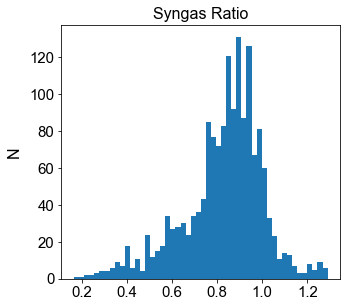

In [42]:
def csv2df(location: str, obj="syngas", nodispersion=True):
    '''Converts .csv file in location to Pandas DataFrame
    returns df, unnormalized features X, and targets y'''
    try: 
        # Reading csv files
        df = pd.read_csv(location, header = 0, index_col = False, encoding = 'utf-8')
        print(df)
    except:
        print(".csv file not found in folder, put file in same folder as this .ipynb notebook")
    
    try: 
        # Reading data to see if they are formatted correctly
        if nodispersion:
            try:
                df = df.drop(columns=["Ni Dispersion"])
                df = df.dropna(subset=["Syngas_Ratio", "Ni Particle Size"])
            except:
                print("Error occured during filtering")
        else:
            df = df.dropna(subset=["Syngas_Ratio", "Ni Particle Size", "Ni Dispersion"])
        try:
            # Filter the top and bottom 0.5 percentile for y
            df = filtery(df) 
            features = df.loc[:,"Ratio of CH4 in Feed":"GHSV"] 
            features = features.dropna(axis=0)
        except:
            print("Error occurred when extracting features")
        if obj == "syngas":
            # In the spreadsheet,take the column with title "syngas ratio" as the targets   
            target = df.loc[:, "Syngas_Ratio"] 
            target = target.dropna(axis=0)
            features = df.loc[:,"Ratio of CH4 in Feed":"GHSV"] 
        elif obj == "conv":
            target = df.loc[:, "CO2 Conversion"]
            target = df.loc[:, "CH4 Conversion"]
            features = df.loc[:,"Ratio of CH4 in Feed":"GHSV"] 

    
        # Plot Distribution of target values
        ticksize = 15
        fsize = 16
        plt.figure(figsize=(5,14/3))
        plt.hist(target, bins=50)
        plt.xticks(fontsize= ticksize)
        plt.yticks(fontsize= ticksize)
        plt.ylabel("N",fontsize=fsize)
        #plt.xlabel("Syngas Ratio",fontsize=18)
        plt.title("Syngas Ratio",fontsize=fsize)
        plt.show()

    except: 
        print("csv file is read, but there is a formatting error")
    return df, features, target

# NOTE: the csv just have to be in the same folder as this .ipynb file 
df, X, y = csv2df("Final Complied.csv",obj = 'syngas', nodispersion=True)

Plot distributions of the features in the dataset

1620


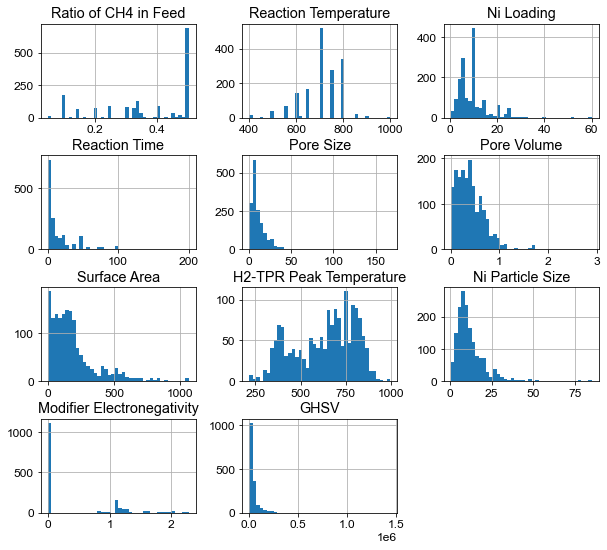

In [43]:
def plthist(df):
    '''plot histograms of features values'''
    thres = 0.005
    upperq = 1-thres 
    df3 = df
    fig = df3.hist(bins=40, figsize=(10, 9))
    print(len(df3.index))
    fig = plt.gcf()
    fig.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

plthist(X)

Define helper functions for successive function calls

In [44]:
def pltshap(model, features, cat=True):
    '''To plot shap figures'''
    if cat:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(features,check_additivity=False)
    else:
        explainer = shap.Explainer(model, features)
        shap_values = explainer(features,check_additivity=False)
    
    '''plt.figure(), shap.plots.waterfall(shap_values[0]), plt.show()'''
    plt.figure()
    shap.plots.beeswarm(shap_values)
    plt.show()
    
def evalscore(model, Xtrain, Xtest, ytrain, ytest):
    '''returns model score, trainMSE, testMSE, trainR2, testR2'''
    score = model.score(Xtest, ytest)
    model_train_pred = model.predict(Xtrain)
    model_test_pred = model.predict(Xtest)
        
    r2train = r2_score(ytrain, model_train_pred)#, multioutput='raw_values')
    r2test = r2_score(ytest, model_test_pred)#, multioutput='raw_values')
        
    trainMSE = mean_squared_error(ytrain, model_train_pred)#, multioutput='raw_values')
    trainMSE = trainMSE **0.5
        
    testMSE = mean_squared_error(ytest, model_test_pred)#, multioutput='raw_values')
    testMSE = testMSE**0.5
        
    return score, trainMSE, testMSE, r2train, r2test, model_train_pred, model_test_pred

def plotfeatureimportance(importances, perimportance, printf=False):
    '''To plot feature importance sorted in terms of priority'''
    indices = np.argsort(importances)[::-1] 
    # Print the feature ranking
    if printf:
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    # Plot the feature importances
    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot(1, 2, 1)
    y_ticks = np.arange(len(X.columns.values))
    ax.barh(y_ticks,importances[indices],height=0.6)
    ax.set_yticklabels(X.columns[indices])
    ax.set_yticks(y_ticks)
    ax.invert_yaxis()
    label_x = ax.get_xticklabels()
    plt.tick_params(axis='x',labelsize=14) 
    plt.tick_params(axis='y',labelsize=14)
    plt.xlabel('Value of Importance', fontsize=16)        
    plt.title("Feature Importance Plot", fontsize=17)

    # Plot the permutation importance
    plt.subplot(1, 2, 2)
    sorted_idx = perimportance.importances_mean.argsort()
    plt.boxplot(perimportance.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx])
    plt.title("Permutation Importance (test set)", fontsize=17)
    plt.xlabel("Permutation Importance of Feature", fontsize=16)
    plt.tick_params(axis='x',labelsize=14) 
    plt.tick_params(axis='y',labelsize=14)
    fig.tight_layout()
    plt.show()

def plotscatter(ytrain, ytest, ytrainpred, ytestpred):    
    plt.figure(figsize=(7,7)) # create basic scatterplot     
    plt.plot(ytrain, ytrainpred, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)

    m, b = np.polyfit(ytest, ytestpred, 1) # obtain m (slope) and b(intercept) of linear regression line
    plt.plot(ytest, ytestpred, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5) # Scatter plot
    plt.plot(ytest, m*ytest+b, color='green', linewidth=2)  # add linear regression line to scatterplot
    plt.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=12, loc = 'lower right')
    plt.xlabel("Actual Targets", fontsize = 15)
    plt.ylabel("Predicted Targets", fontsize = 15)
    plt.title("Model Prediction", fontsize = 16, weight="bold")
    plt.show()

def twod_pdp(model, Xtrain, feature_tuple, grid=40, low=0,up=0.95):
    plt.figure()
    fig = PartialDependenceDisplay.from_estimator(model,Xtrain, features = [feature_tuple], feature_names=X.columns,
    n_jobs=3, grid_resolution=grid, percentiles = (low,up), line_kw = {"linestyle":"--","linewidth":2, "marker":"o", "markersize":3})
    plt.show()

def threedpdp(model, Xtrain, feature_tuple, grid=40, inv_y=False, inv_x=False):
    titlesize = 20
    ticksize = 15
    labelsize = 18
    plt.rc('font', size=14)
    plt.rcParams['axes.labelpad'] = 20
    xname, yname = X.columns[feature_tuple[0]], X.columns[feature_tuple[1]]
    fig = plt.figure(figsize=(9,9))
    pdp = partial_dependence(model, Xtrain, features=feature_tuple, kind="average", grid_resolution=grid)
    xval, yval = pdp["values"][0], pdp["values"][1]
    XX, YY = np.meshgrid(xval, yval)
    Z = pdp.average[0].T      
    ax = fig.add_subplot(projection="3d")

    fig.add_axes(ax)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap="viridis", edgecolor="k")
    ax.set_xlabel(xname, fontsize=labelsize)

    if inv_y:
        buffer = (max(yval)-min(yval))*0.03
        ax.set_ylim(max(yval)+buffer, min(yval)-buffer)

    if inv_x:
        buffer = (max(xval)-min(xval))*0.03
        ax.set_xlim(max(xval)+buffer, min(xval)-buffer)
    if yname == "GHSV":
        # The extra spaces are to format the ylabel for "GHSV"
        ax.set_ylabel("     GHSV     ", fontsize = labelsize)
        ax.ticklabel_format( axis="y",style="sci", scilimits=(3,3))
        
    else:
        ax.set_ylabel(yname, fontsize=labelsize)
    # pretty init view
    ax.view_init(elev=30, azim=135)
    plt.colorbar(surf, ax=ax,shrink=0.5, pad=0.1)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    ax.zaxis.set_tick_params(labelsize=ticksize)
    plt.title("Partial dependence of Syngas Ratio on \n {} and {}".format(xname, yname), fontsize = titlesize)
    plt.tight_layout()
    plt.show()

def onepdp(model,Xtrain, low=0,up=0.95, **kwargs):
    plt.rcParams['axes.labelpad'] = 7
    options = {"cat":True}
    options.update(**kwargs)
    fig, axes = plt.subplots(figsize=(13, 13))
    #axes.set_title("Partial Dependence Plots of Features on Syngas Ratio", fontsize = 16)
    featureNames = ["Ratio of ${CH_4}$ in Feed", "Reaction Temperature (˚C)", "Ni Loading (%)","Reaction Time (h)","Pore Size (nm)","Pore Volume (cm³/g)","Surface Area (m²/g)","H2-TPR Peak Temperature (˚C)", "Ni Particle Size (nm)", "Modifier Electronegativity","GHSV (ml/gcat/h)"]
    fig = PartialDependenceDisplay.from_estimator(model,Xtrain, features = list(i for i in range(0,Xtrain.shape[1])), feature_names=featureNames,
    n_jobs=3, grid_resolution = 25, ax=axes, percentiles = (0,1), line_kw = {"linestyle":"--","linewidth":2, "marker":"o", "markersize":3.2})

    for i in fig.axes_:
        for j in i:
            if (j!=None):
                j.xaxis.label.set_size(16)
                j.yaxis.label.set_size(16)
                j.tick_params(axis='both', which='major', labelsize=14)
                if options["cat"]:
                    j.set_yticks((0.6,0.7,0.8,0.9))
                    j.set_yticklabels((0.6,0.7,0.8,0.9))
                    j.set_ylabel("Syngas Ratio", fontsize = 16)
                    j.set_ylim(0.6,0.95)
                    
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
    plt.show()

def plotpartial(model,Xtrain, oneway=True, twoway=False,catalyst=True, process = True):
    '''To plot partial dependence plots'''    
    t1 = time.time()
    if oneway:
        onepdp(model, Xtrain)
    t2 = time.time()

    print("Time taken for one way pdp is {:.2f} seconds".format(t2-t1))
    if twoway: 
        # Catalyst properties: [(4,5),(4,8),(2,8),(6,8),(7,8)]
        # Process Parameters; [(0,10),(2,10),(1,10)]
        if catalyst:
            catalst = [(4,5),(4,8),(2,8),(6,8),(7,8)]
            for i in catalst:
                t3 = time.time()
                if i == (4,5):
                    threedpdp(model, Xtrain, i, grid=40, inv_y=True)
                else:
                    threedpdp(model, Xtrain, i, grid=40)
                t4 = time.time()
                print("Time taken for 1st two way pdp is {:.2f} seconds".format(t4-t3))

        if process: 
            process = [(0,10),(2,10),(1,10)]
            for j in process:
                t4 = time.time()
                if (j == (0,10)): # If plotting ch4 ratio vs ghsv, invert x axis
                    threedpdp(model, Xtrain, j, grid=40,inv_x=True)
                elif (j==(0,1)): # If plotting ch4 ratio vs temp, invert both axis
                    threedpdp(model, Xtrain, j, grid=40,inv_x=True,inv_y=True)
                else: 
                    threedpdp(model, Xtrain, j, grid=40)
                t5 = time.time()
                print("Time taken for 1st two way pdp is {:.2f} seconds".format(t5-t4))


Splitting Training Dataset (90%) and Testing Data (10%) <br>

In [45]:
def splitdata(X,y,r,scale=False):
    '''Takes in features (X) and target/s (y) and split data sets
    Outputs the Normalized features (X) and targets (y)'''
    test_percent = 0.10 # Part of data used for testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_percent, random_state = r) #random_state = 42
    
    # If normalization is required, normalize input features (x) into normlized features (X) using MinMaxScaler
    # Or try using MinMaxScaler(), StandardScaler(),
    # Not used here
    if scale:
        norm_x = StandardScaler().fit(X_train) # transform training data
        X_train = norm_x.transform(X_train) # transform testing dataabs
        X_test = norm_x.transform(X_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitdata(X, y, 56)


Train the RF model and test model performance

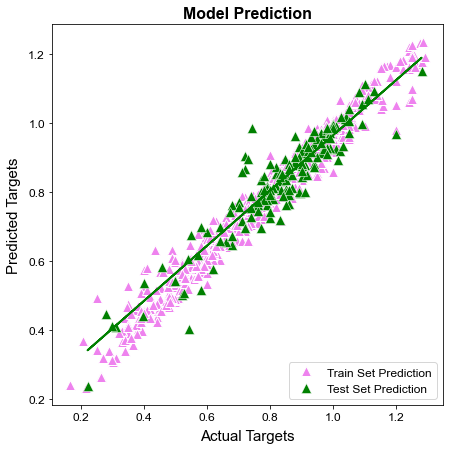

[0.06405719039516991, 0.8650468231769352]


In [46]:
def rf(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''Random Forest Regressor, returns mean test score and plot relevant plots
    By default we dont plot and print anything'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False, "shap":False, "doprint":False, "plottree":False}
    options.update(kwargs)
    model_num = options["model_num"]

    FtrainR2, FtestR2 = 0, 0 # Training and Testing R square
    FtrainRMSE, FtestRMSE  = 0, 0 # Training and Testing residual MSE
    FScore = 0 # Cumulative Score
    
    for j in range(0,model_num):
        RF = RandomForestRegressor(n_estimators=2000, max_depth=100,random_state=0).fit(Xtrain, ytrain)
        fscore, trainMSE, testMSE, rtrain, rtest, RF_train_pred, RF_test_pred = evalscore(RF, Xtrain, Xtest, ytrain, ytest)
        FScore += fscore
        FtrainR2 += rtrain
        FtestR2 += rtest
        FtrainRMSE += trainMSE
        FtestRMSE += testMSE

    if options["scatterplot"]:
        plotscatter(ytrain, ytest, RF_train_pred, RF_test_pred)

    if options["partialdep"]:
        plotpartial(RF,Xtrain)
        
    if options["featureplot"]:
        '''To plot partial dependence plot for RF'''
        importances = RF.feature_importances_
        perimportance = permutation_importance(RF, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)
    
    if options["shap"]:
        pltshap(RF, Xtrain)

    if options["doprint"]:
        print("The RF average training score is "), print(FtrainR2/model_num) 
        print("The RF average training Root-mean-square deviation is "), print(FtrainRMSE/model_num)
        print("The RF average testing Root-mean-square deviation is "), print(FtestRMSE/model_num)
    
    return [FtestRMSE/model_num,FScore/model_num], [ytrain, ytest, RF_train_pred, RF_test_pred]

score, rflst = rf(X_train, X_test, y_train, y_test, scatterplot=True, featureplot=False, partialdep=False)
print(score)

Train the GBR model and test the model performance

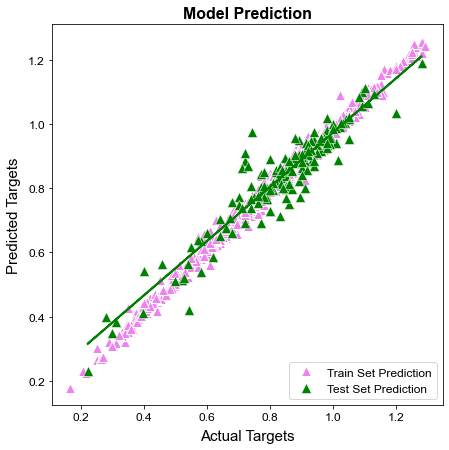

[0.05731972399140751, 0.8919423493674397]


In [47]:
def gbr(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''Gradient Boosting Tree Training, returns Score
    By default we dont print anything'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False,"doprint":False, "shap": False, "plottree":False}
    options.update(kwargs)
    model_num = options["model_num"]
    
    GtrainR2, GtestR2 = 0, 0 # Training and Testing R square
    GtrainRMSE, GtestRMSE  = 0, 0 # Training and Testing residual MSE
    GScore = 0 # Cumulative Score
    
    for j in range(0,model_num):
        lr = 50/10000
        GBR = GradientBoostingRegressor(n_estimators=1000, learning_rate=lr, subsample=0.7, max_depth = 10, random_state = 1).fit(Xtrain, ytrain)
        
        gscore, trainMSE, testMSE, rtrain, rtest, GBR_train_pred, GBR_test_pred = evalscore(GBR, Xtrain, Xtest, ytrain, ytest)
        GScore += gscore
        GtrainR2 += rtrain
        GtestR2 += rtest
        GtrainRMSE += trainMSE
        GtestRMSE += testMSE
    
    if options["scatterplot"]:
        plotscatter(ytrain, ytest, GBR_train_pred, GBR_test_pred)

    if options["partialdep"]:
        plotpartial(GBR, Xtrain, gbr=True)
        
    if options["featureplot"]:
        '''To plot partial dependence plot for GBR'''
        importances = GBR.feature_importances_
        perimportance = permutation_importance(GBR, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)
    
    if options["shap"]:
        pltshap(GBR, Xtrain)


    if options["doprint"]:
        print("The GBR average training score is "), print(GtrainR2/model_num) 
        print("The GBR average training Root-mean-square deviation is "), print(GtrainRMSE/model_num)
        print("The GBR average testing Root-mean-square deviation is "), print(GtestRMSE/model_num)

    return [GtestRMSE/model_num, GScore/model_num], [ytrain, ytest, GBR_train_pred, GBR_test_pred]

score, gbrlst = gbr(X_train, X_test, y_train, y_test, scatterplot=True,featureplot=False,partialdep=False)
print(score)

Train the XGB model, Not included in the final study

In [48]:
def xgb(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''Extreme Gradient Boosting Tree Training, returns testing score
    By Default no plots are displayed'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False,"doprint":False, "shap": False}
    options.update(kwargs)
    model_num = options["model_num"]
    XtrainR2, XtestR2 = 0, 0 # Training and testing R square
    XtrainRMSE, XtestRMSE = 0, 0 # training residual MSE
    XScore = 0 # Cumulative Score

    for j in range(0,model_num):
        '''XGB''' # squaredlogerror for syngas ratio and squarderror for conversion
        XGB = XGBRegressor(objective='reg:squarederror', learning_rate=0.15).fit(Xtrain, ytrain)
        xscore, trainMSE, testMSE, rtrain, rtest, XGB_train_pred, XGB_test_pred = evalscore(XGB, Xtrain, Xtest, ytrain, ytest)
        XScore += xscore
        XtrainR2 += rtrain
        XtestR2 += rtest
        XtrainRMSE += trainMSE
        XtestRMSE += testMSE

    if options["partialdep"]:
        plotpartial(XGB,Xtrain)

    if options["scatterplot"]:
        plotscatter(ytrain, ytest, XGB_train_pred, XGB_test_pred)
    
    if options["featureplot"]:
        '''To plot partial dependence plot for XGB'''
        importances = XGB.feature_importances_
        perimportance = permutation_importance(XGB, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)

    if options["shap"]:
        pltshap(XGB, Xtrain)
      
    if options["doprint"]:
        print("The XBR average training score is "), print(XtrainR2/model_num) 
        print("The XBR average training Root-mean-square deviation is "), print(XtrainRMSE/model_num)
        print("The XBR average testing Root-mean-square deviation is "), print(XtestRMSE/model_num)
    average_XScore = XScore/model_num
    return average_XScore, [ytrain, ytest, XGB_train_pred, XGB_test_pred]

#score, xgblst = xgb(X_train, X_test, y_train, y_test, shap = True)
#print(score)

Train the CAT model and plot the PDPs

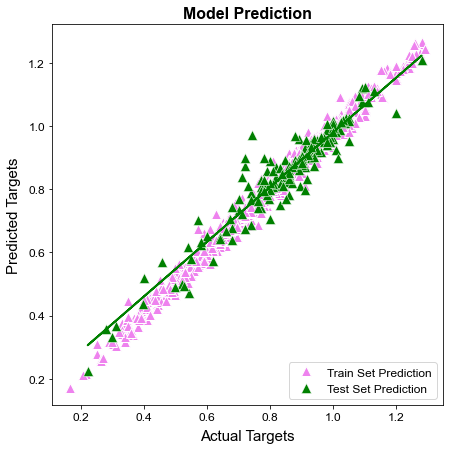

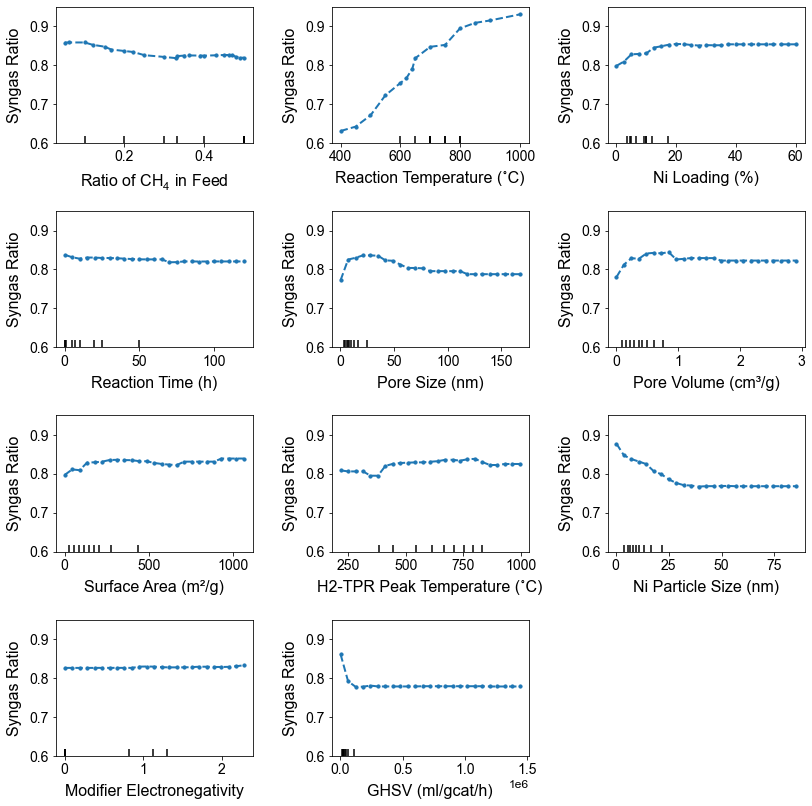

Time taken for one way pdp is 3.91 seconds


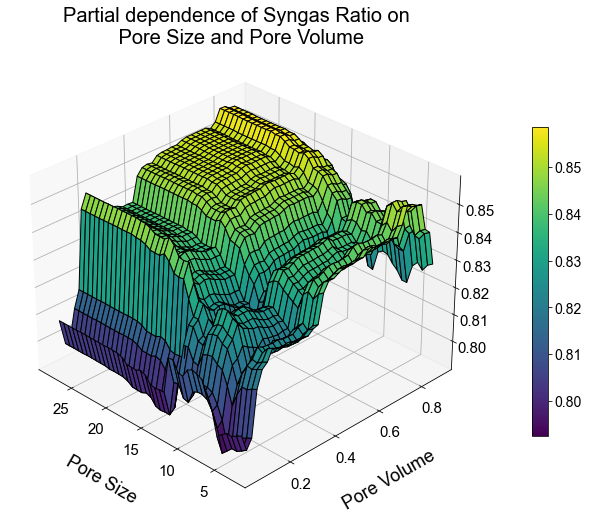

Time taken for 1st two way pdp is 22.34 seconds


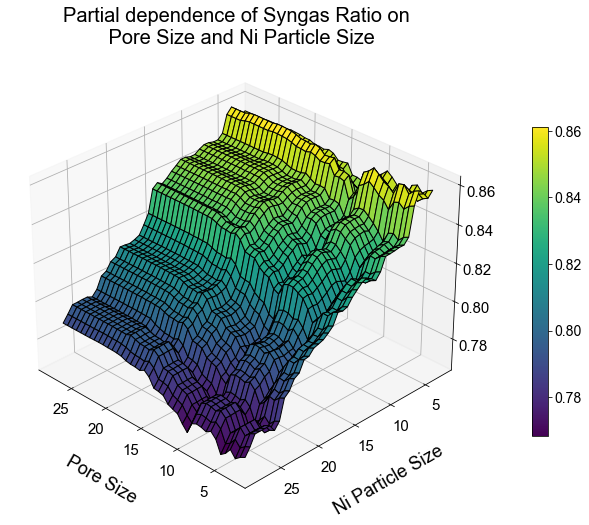

Time taken for 1st two way pdp is 20.42 seconds


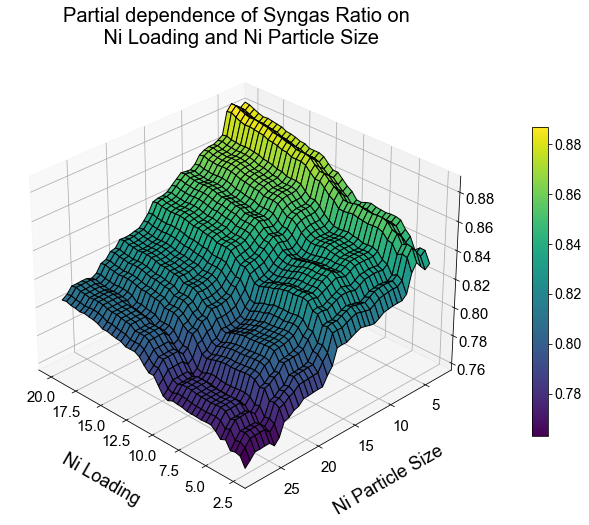

Time taken for 1st two way pdp is 21.10 seconds


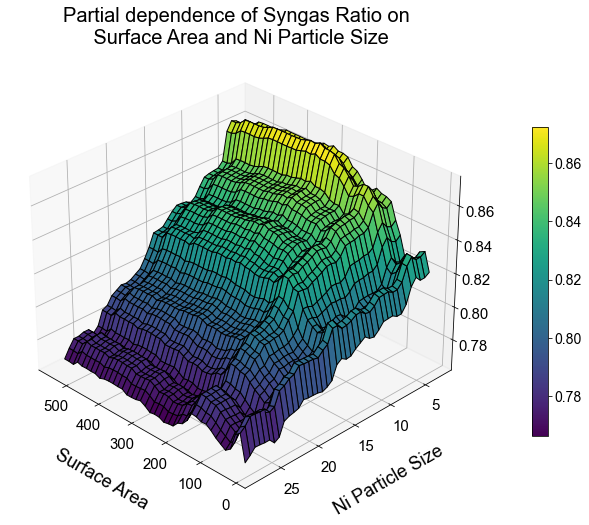

Time taken for 1st two way pdp is 31.63 seconds


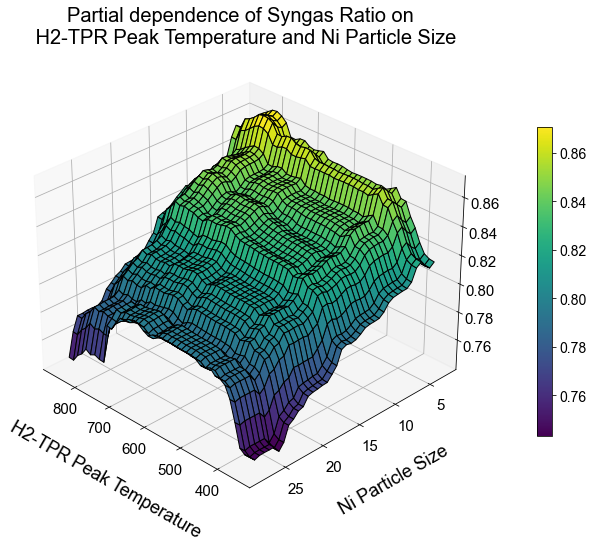

Time taken for 1st two way pdp is 20.98 seconds


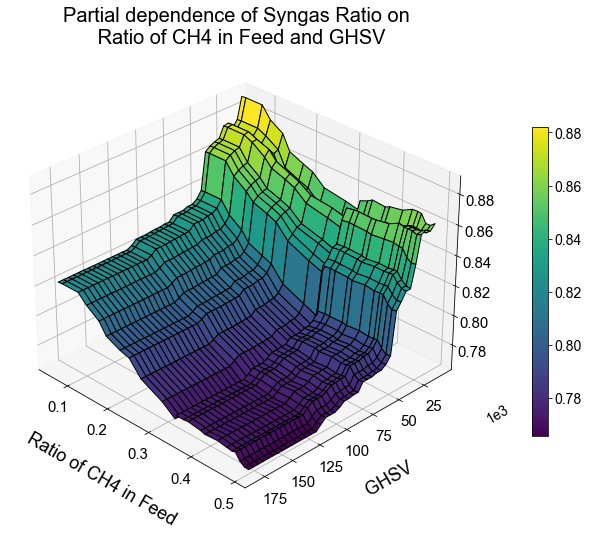

Time taken for 1st two way pdp is 12.19 seconds


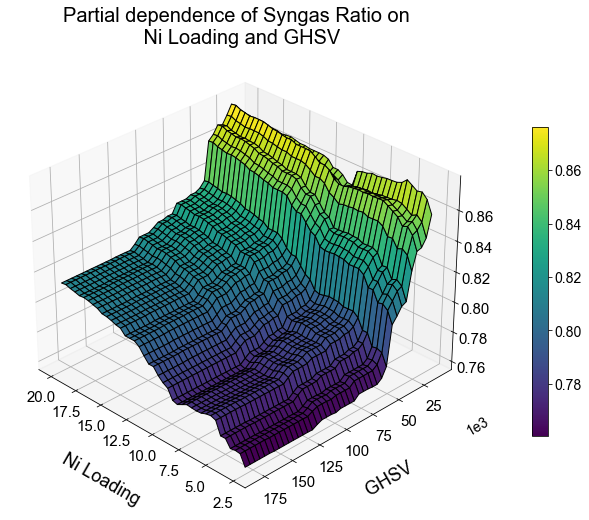

Time taken for 1st two way pdp is 21.42 seconds


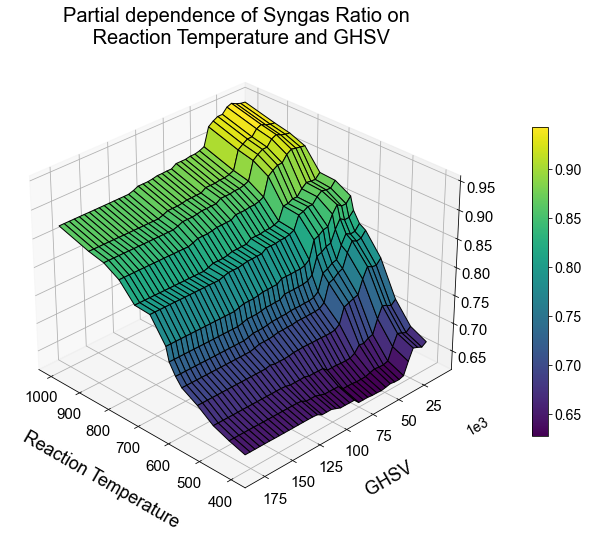

Time taken for 1st two way pdp is 7.93 seconds


FixedFormatter should only be used together with FixedLocator


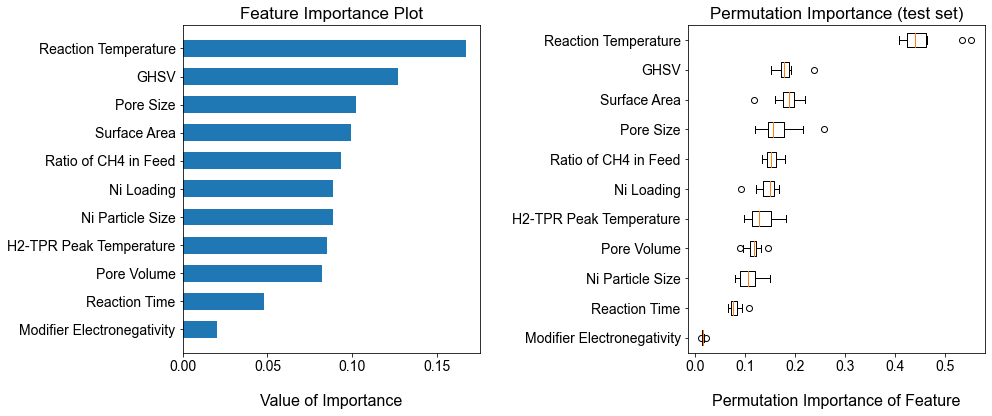

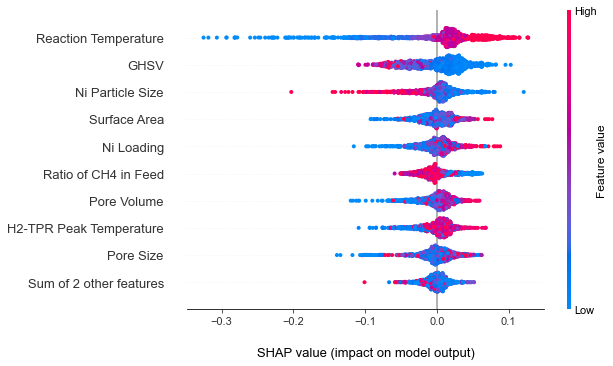

[0.052731064074068926, 0.9085506947806166]


In [49]:
def cat(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''CAT Gradient Boosting Tree Training and Performance testing
    Takes the normalized features and labels to return a training score'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False,"doprint":False, "savemodel":False, "shap":False}
    options.update(kwargs)
    model_num = options["model_num"]
    CtrainR2, CtestR2 = 0, 0 # Training and Testing R square
    CtrainRMSE, CtestRMSE = 0, 0 # Training and Testing residual MSE
    CScore = 0 # Cumulative Score
    
    pool = Pool(Xtrain, ytrain, feature_names=list(X.head(0)))
    for j in range(0,model_num):
        '''CAT Regressor, tune the n_estimators and learning_rate'''
        CAT = CatBoostRegressor(n_estimators= 1000, depth = 9, verbose=0).fit(pool)

        cscore, trainMSE, testMSE, rtrain, rtest, CAT_train_pred, CAT_test_pred = evalscore(CAT, Xtrain, Xtest, ytrain, ytest)
        CScore += cscore
        CtrainR2 += rtrain
        CtestR2 += rtest
        CtrainRMSE += trainMSE
        CtestRMSE += testMSE
       
    if options["scatterplot"]:
        plotscatter(ytrain, ytest, CAT_train_pred, CAT_test_pred)
        
    if options["partialdep"]:
        plotpartial(CAT,Xtrain, oneway=True, twoway=True)
        
    if options["featureplot"]:
        '''To plot partial dependence plot for CAT'''
        importances = (CAT.feature_importances_/100)
        perimportance = permutation_importance(CAT, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)

    if options["shap"]:
        pltshap(CAT, Xtrain, cat=True)    
        
    if options["doprint"]:
        print("The CAT average training score is "), print(CtrainR2/model_num) 
        print("The CAT average training Root-mean-square deviation is "), print(CtrainRMSE/model_num)
        print("The CAT average testing Root-mean-square deviation is "), print(CtestRMSE/model_num)

    return CAT, [CtestRMSE/model_num,CScore/model_num], [ytrain, ytest, CAT_train_pred, CAT_test_pred]
syngasMdl, score, cat_lst = cat(X_train, X_test, y_train, y_test, scatterplot=True, shap=True, featureplot=True, partialdep=True)
print(score)

To plot regression plot for RF, GBR, CAT together

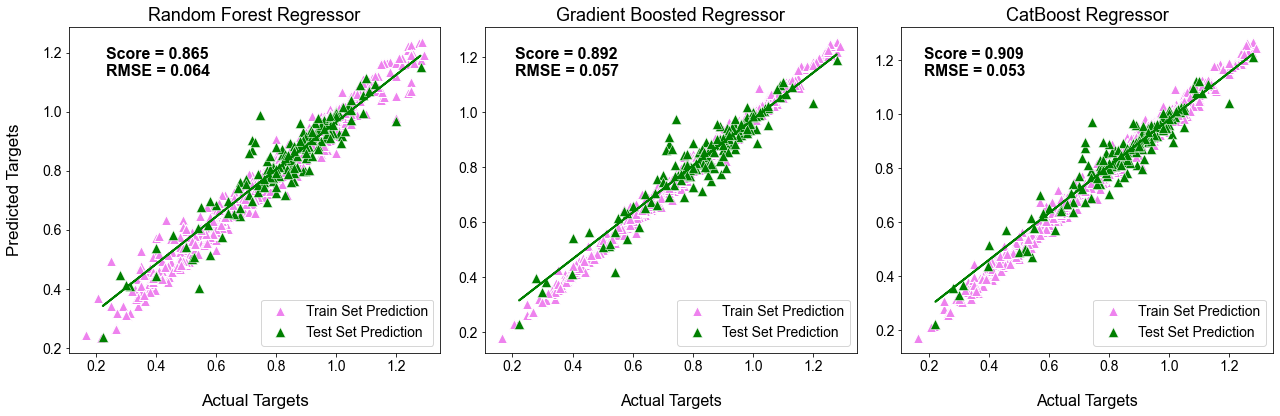

In [50]:
def pltall():
    '''To combine regression plots for all models
    [ytrain, ytest, CAT_train_pred, CAT_test_pred]'''
    textsize = 17
    ticksize = 14
    rfs, rfl = rf(X_train, X_test, y_train, y_test)
    gbrs, gbrl = gbr(X_train, X_test, y_train, y_test)
    mdl,cats, catl = cat(X_train, X_test, y_train, y_test)
    
    rtrain, rtest, rtrainpred, rtestpred = tuple(rfl)
    plt.figure(figsize=(18,6))
    ax = plt.subplot(1, 3, 1)
    ax.plot(rtrain, rtrainpred, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)
    m, b = np.polyfit(rtest, rtestpred, 1)
    ax.plot(rtest, rtestpred, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5)
    ax.plot(rtest, m*rtest+b, color='green', linewidth=2)
    ax.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=14, loc = 'lower right')
    plt.xlabel("Actual Targets", fontsize = textsize)
    plt.ylabel("Predicted Targets", fontsize = textsize)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    ax.text(0.1, 0.85,'Score = {:.3f} \nRMSE = {:.3f}'.format(rfs[1], rfs[0]),
     transform = ax.transAxes, fontsize=16, fontweight = 'semibold')
    plt.title("Random Forest Regressor",fontsize=18)
    
    gtrain, gtest, gtrainpred, gtestpred = tuple(gbrl)
    ax2 = plt.subplot(1, 3, 2, sharex=ax)
    ax2.plot(gtrain, gtrainpred, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)
    m, b = np.polyfit(gtest, gtestpred, 1)
    ax2.plot(gtest, gtestpred, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5)
    ax2.plot(gtest, m*rtest+b, color='green', linewidth=2)
    ax2.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=14, loc = 'lower right')
    plt.xlabel("Actual Targets", fontsize = 16)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    ax2.text(1.2, 0.85,'Score = {:.3f} \nRMSE = {:.3f}'.format(gbrs[1], gbrs[0]),
     transform = ax.transAxes, fontsize=16, fontweight = 'semibold')
    #plt.ylabel("Predicted Targets", fontsize = 12)
    plt.title("Gradient Boosted Regressor",fontsize=18)

    ctrain, ctest, ctrainpred, ctestpred = tuple(catl)
    ax3 = plt.subplot(1, 3, 3, sharex=ax)
    ax3.plot(ctrain, ctrainpred, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)
    m, b = np.polyfit(ctest, ctestpred, 1)
    ax3.plot(ctest, ctestpred, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5)
    ax3.plot(ctest, m*rtest+b, color='green', linewidth=2)
    ax3.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=14, loc = 'lower right')
    ax3.text(2.3, 0.85,'Score = {:.3f} \nRMSE = {:.3f}'.format(cats[1], cats[0]),
     transform = ax.transAxes, fontsize = 15.5 , fontweight = 'semibold')
    plt.xlabel("Actual Targets", fontsize = 16)
    #plt.ylabel("Predicted Targets", fontsize = 12)
    plt.title("CatBoost Regressor", fontsize=18)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    plt.tight_layout()
    plt.show()

pltall()